Standardowe biblioteki

In [1]:
# Świetna biblioteka, ale niestety kompatybilna tylko z systemem linux
#import ydf

import xgboost as xgb
import pandas as pd
import optuna
import optunahub
import seaborn as sns
from sklearn.model_selection import train_test_split # Do podziału danych na zbiór treningowy i walidacyjny
from sklearn.metrics import mean_squared_error # Do oceny modelu
from sklearn.model_selection import KFold # Do podziału danych na zbiór treningowy i walidacyjny metodą Kfold
import numpy as np

C:\Users\Joint\miniforge3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Założenia
1. Będę trenował moje modele z biblioteki sci-learn

Wczytywanie danych na których będę dokonwwał trenowania

In [2]:
train_ds_full = pd.read_csv("./Future Engenering/Przetworzone dane/Normalne_dane_treningowe.csv")

test_ds = pd.read_csv("./Future Engenering/Przetworzone dane/Test_ZimputowaneDane_MetodaLGB_zakodowaneWartościTekstowe.csv")

# Wyszukanie wartości object na category xgboost by automatycznie je zakodował.
# object_cols = test_ds.select_dtypes(include=['object']).columns

# Ręczne filtrowanie kolumn typów ponieważ z jakiegoś powodu funkcja wyszukująca nie działa prawidłowo.
object_cols = []

for col in train_ds_full:
    if train_ds_full[col].dtype.name != 'float64' and train_ds_full[col].dtype.name != 'int64':
        object_cols.append(col)

# Musimy przekonwertować kolumny zawierające wartości kategoryczne. 
# Jest to niezbędny krok w celu zautomatyzowania kodowania tych wartości, które są wykorzystywane w funkcji XGBoost.
for col in object_cols:
    test_ds[col] = test_ds[col].astype('category')
    train_ds_full[col] = train_ds_full[col].astype('category')

train_ds_full = train_ds_full.drop(columns=['Unnamed: 0'])
test_ds = test_ds.drop(columns=['Unnamed: 0'])

# Chociaż kolumna zawiera wartości liczbowe, jest opisana jako cecha kategoryczna, więc musimy zmienić jej typ danych.
train_ds_full['MSSubClass'] = train_ds_full['MSSubClass'].astype('category')
test_ds['MSSubClass'] = test_ds['MSSubClass'].astype('category')

object_cols.clear()

for col in test_ds:
    if test_ds[col].dtype.name == 'object':
        object_cols.append(col)

print(object_cols)

for col in object_cols:
    print(col)
    test_ds[col] = pd.to_numeric(test_ds[col], errors='coerce').astype('float64')

print(train_ds_full.shape)
print(test_ds.shape)

['BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'GarageArea', 'count_of_porch', 'sum_of_area_porch']
BsmtFullBath
BsmtHalfBath
GarageCars
GarageArea
count_of_porch
sum_of_area_porch
(1445, 65)
(1459, 64)


# Podział danych
Podział danych musi nastąpić by optiuna miała dzięki czemu porównywać swoje dokonane analizy.
Dodatkowo podział danych musi nastąpić poprzez stratyfikacje bo danych jest za mało i to doprowadzało by do błędnych wniosków.

# K-Fold podział danych
Dodatkowo umieszcze podział danych w pętli trenowania modelu ponieważ będę trenował z pomocą k-foldowej metody dzielenia danych

In [3]:
# Dzielenie na K-fold
kf = KFold(n_splits=5)

# Rzeczy jakie trzeba wykonać by optiuna działąła
1. Trzeba zdefiniować funkcję "objective" z argumetem "trial"
2. Tworzymy słownik hiperparametrów i w nim za pomocą funkcji "trial" ustalamy przedziały liczb które będą wstawiane w tych hiperparametrach.
3. ta funcja musi zwracać metrykę według której będą zmieniane hiperparametry

In [4]:
def objective(trial):
    # Sugeruj wartości hiperparametrów, które Optuna ma przetestować
    params_to_learn = {
        # "max_depth": trial.suggest_int("max_depth", 4, 13),
        "n_estimators": trial.suggest_int("n_estimators", 300, 900),
        "max_leaves" : trial.suggest_int("max_leaves", 15, 100),
        "max_bin": trial.suggest_int("max_bin", 10, 500),
        "learning_rate": trial.suggest_float("learning_rate", 0.1, 0.5, log=True),
        "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        "reg_alpha": trial.suggest_float("reg_alpha", 1, 5.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1, 5.0, log=True),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10)
    }

    model = xgb.XGBRegressor(
        enable_categorical = True,
        **params_to_learn
    )

    table_of_mean_kfold_predictions = []
    
    for i, (train_index, validation_index) in enumerate(kf.split(train_ds_full)):

        train_ds_subset = train_ds_full.iloc[train_index]
        # Wartość ta jest wymagana przez funkcję regresji XGBoost w celu identyfikacji zmiennej docelowej.
        train_ds_subset_saleprice = train_ds_subset["SalePrice"]

        validation_ds_subset = train_ds_full.iloc[validation_index]
        validation_ds_subset_saleprice = validation_ds_subset["SalePrice"]

        # Trenowanie modelu.
        model.fit(train_ds_subset, train_ds_subset_saleprice)

        # Przewiduje wartości na zbiorze walidacyjnym
        predictions = model.predict(validation_ds_subset)
        
        # Oblicza błąd (RMSE - Root Mean Squared Error), który chcemy minimalizować
        rmse = np.sqrt(mean_squared_error(validation_ds_subset_saleprice, predictions))
        
        table_of_mean_kfold_predictions.append(rmse)
        print(np.mean(table_of_mean_kfold_predictions))

    return np.mean(table_of_mean_kfold_predictions)

In [5]:
# Chcemy zminimalizować błąd, więc direction='minimize'
study = optuna.create_study(storage="sqlite:///db.sqlite3",
                            study_name="przewidywanie-cen-domow21",
                            direction='minimize')
study.optimize(objective, n_trials=1, show_progress_bar=True)

print("--------------------------------------")
print("Zakończono optymalizację.")
print(f"Najlepsza próba: {study.best_trial.number}")
print(f"Najlepszy wynik (RMSE): {study.best_value}")
print("Najlepsze hiperparametry:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

# 5. Wytrenuj ostateczny model z najlepszymi znalezionymi parametrami na PEŁNYM zbiorze treningowym
print("--------------------------------------")
print("Trenowanie ostatecznego modelu z najlepszymi parametrami...")
final_model = xgb.XGBRegressor(
    enable_categorical = True,
    **study.best_params
)

final_model = final_model.fit(train_ds_full.drop(columns=['SalePrice']), train_ds_full['SalePrice'])

[I 2025-11-22 12:48:25,674] A new study created in RDB with name: przewidywanie-cen-domow21
  0%|          | 0/1 [00:00<?, ?it/s]

0.08453932210071684
0.1034709753247303
0.10428265576075606
0.09993347535480251


Best trial: 0. Best value: 0.0947968: 100%|██████████| 1/1 [00:02<00:00,  2.18s/it]

0.09479677245839765
[I 2025-11-22 12:48:27,844] Trial 0 finished with value: 0.09479677245839765 and parameters: {'n_estimators': 608, 'max_leaves': 56, 'max_bin': 114, 'learning_rate': 0.30946173966323604, 'booster': 'gbtree', 'reg_alpha': 3.396800491587421, 'reg_lambda': 1.0641945347995507, 'gamma': 2.164002534379116, 'min_child_weight': 3}. Best is trial 0 with value: 0.09479677245839765.
--------------------------------------
Zakończono optymalizację.
Najlepsza próba: 0
Najlepszy wynik (RMSE): 0.09479677245839765
Najlepsze hiperparametry:
  n_estimators: 608
  max_leaves: 56
  max_bin: 114
  learning_rate: 0.30946173966323604
  booster: gbtree
  reg_alpha: 3.396800491587421
  reg_lambda: 1.0641945347995507
  gamma: 2.164002534379116
  min_child_weight: 3
--------------------------------------
Trenowanie ostatecznego modelu z najlepszymi parametrami...


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

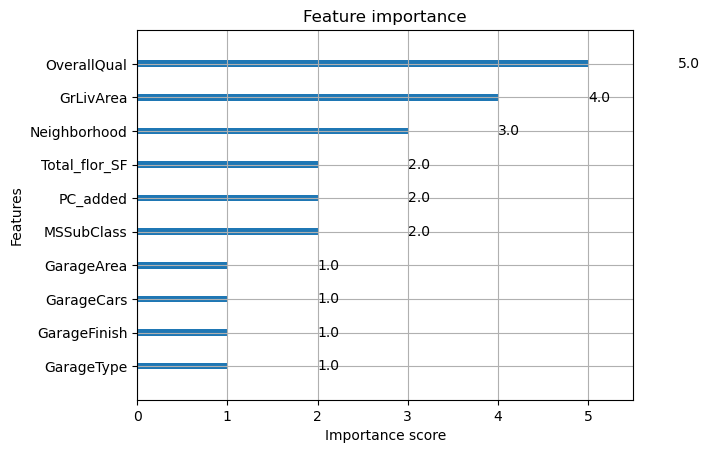

In [6]:
# Plot feature importance
xgb.plot_importance(final_model, max_num_features=10)

In [7]:
# 7. Wykonaj predykcje na zbiorze testowym i zapisz wyniki
print("Generowanie prognoz na zbiorze testowym...")
prognozy = final_model.predict(test_ds)
print(prognozy)
prognozy = np.expm1(prognozy)

lista = []
for i in prognozy:
    lista.append(i)

lista_ids = []
for i in range(1461,2920):
    lista_ids.append(i)

df = pd.DataFrame({'Id': lista_ids, 'SalePrice': lista})
df.to_csv('./Zapisany model i analiza/out_optuna.csv', index=False)

print("Wyniki zapisano do pliku out_optuna.csv")

Generowanie prognoz na zbiorze testowym...
[11.789824  11.933745  12.061905  ... 11.9528055 11.724102  12.163574 ]
Wyniki zapisano do pliku out_optuna.csv


In [8]:
# polecenie do terminala dla optiuny, Trzevba podać główną ścieżkę do pliku
# optuna-dashboard sqlite:///"C:\Users\Joint\Documents\Moje projekty\Przewidywanie cen domów\db.sqlite3"